Here I first test the performance of tiny audoencoder -- it still does a great job on our data. 

# Library


In [1]:
!pip install diffusers
pip install wrapt

In [23]:
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from diffusers import AutoencoderTiny


import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim

from torch.utils.data import SubsetRandomSampler,Subset,DataLoader, random_split

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib import cm
import matplotlib.colors as mcolors




# SD + VAE for swarming colonies

## Data

In [186]:
def encode_img(input_img):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    input_img = input_img.to(torch.float16)
    input_img = input_img.to(device)
#    if len(input_img.shape)<4:
#        input_img = input_img.unsqueeze(0)
    with torch.no_grad():
        output = vae.encode(input_img) 
    return output.latents
#    return latent.latent_dist.sample()


def decode_img(latents):
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach()
    return image


def load_images_from_folder(folder, limit=10):
    images = []
    for filename in os.listdir(folder)[:limit]:  # Process only the first 10 files
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images


def pil_to_tensor(images):
    # Convert grayscale to RGB if necessary and normalize
    tensors = [torch.tensor(np.array(img.convert("RGB")), dtype=torch.float16) / 255.0 for img in images]
    return torch.stack(tensors).permute(0, 3, 1, 2)  # Convert to (batch, channels, height, width)

def tensor_to_pil(tensor):
    tensor = tensor.permute(0, 2, 3, 1)  # Convert to (batch, height, width, channels)
    return [Image.fromarray((img.numpy() * 255).astype('uint8')) for img in tensor]

In [187]:
folder_path = "colonies_png"  # replace with your folder path
images = load_images_from_folder(folder_path)
image_tensors = pil_to_tensor(images)

## Model

In [188]:
# Load pretrained VAE model
#vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

#according to stablityai, the following version is one of the two most updated versions of the SD_VAE. This version emphasizes on reconstruction accuracy.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = AutoencoderTiny.from_pretrained("madebyollin/taesd", torch_dtype=torch.float16)
vae = vae.to(device)
vae.eval()

AutoencoderTiny(
  (encoder): EncoderTiny(
    (layers): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): AutoencoderTinyBlock(
        (conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU()
          (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (skip): Identity()
        (fuse): ReLU()
      )
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (3): AutoencoderTinyBlock(
        (conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU()
          (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  

torch.Size([10, 4, 64, 64])
torch.Size([10, 3, 512, 512])


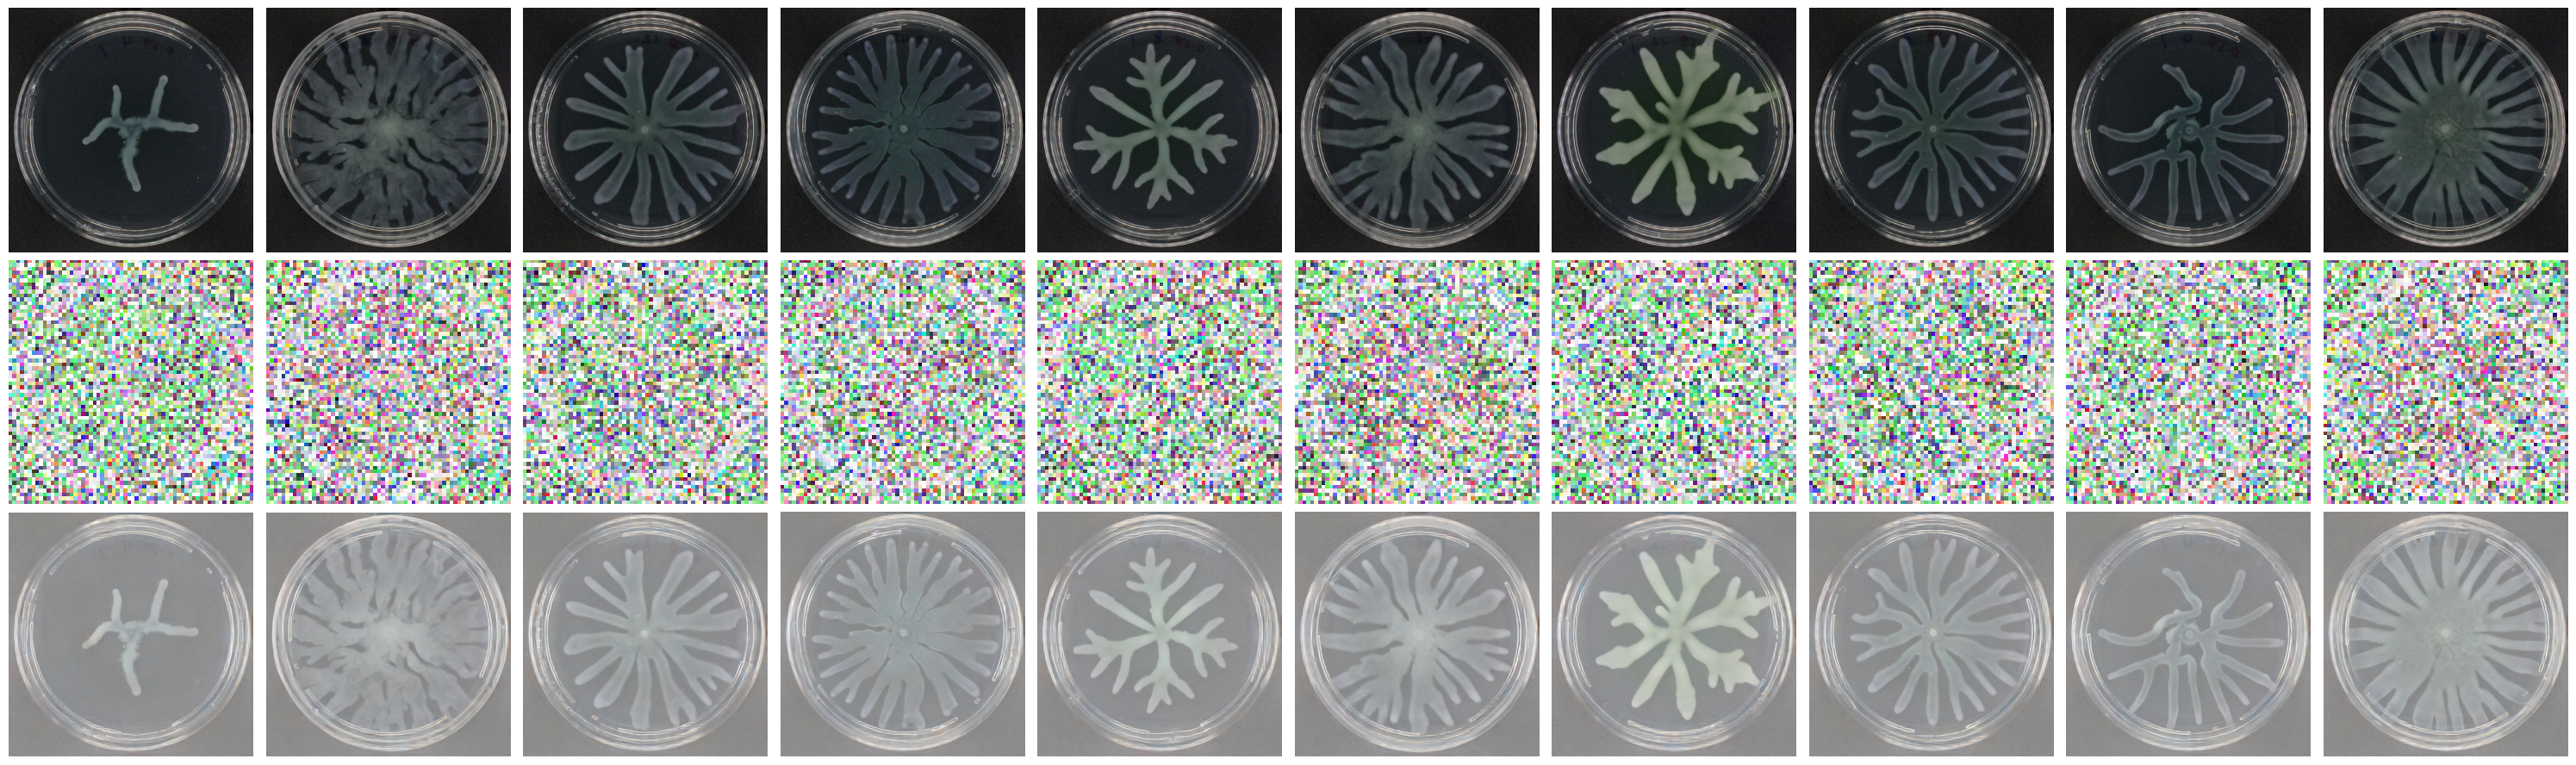

In [189]:
# get latent
encoded = encode_img(image_tensors)
latent_images = tensor_to_pil(encoded.cpu())
print(encoded.shape)

# reconstruct images
decoded_tensors = decode_img(encoded).cpu() 
decoded_images = tensor_to_pil(decoded_tensors)
print(decoded_tensors.shape)


# Display the images
fig, axs = plt.subplots(3, len(images), figsize=(3 * len(images), 9))
for idx, img in enumerate(images):
    # original
    axs[0, idx].imshow(img)
    axs[0, idx].axis('off')
    # latent
    axs[1, idx].imshow(latent_images[idx])
    axs[1, idx].axis('off')
    # recon
    axs[2, idx].imshow(decoded_images[idx])
    axs[2, idx].axis('off')
plt.tight_layout()
plt.show()


## TSNE

OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

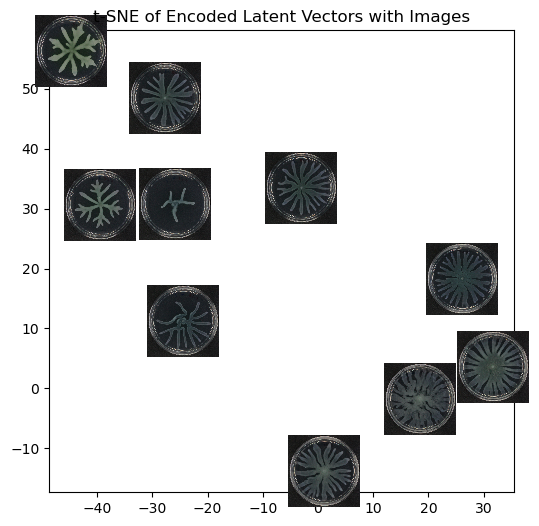

In [205]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def imscatter(x, y, images, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    artists = []
    for x0, y0, img0 in zip(x, y, images):
        imagebox = OffsetImage(img0, zoom=zoom)
        ab = AnnotationBbox(imagebox, (x0, y0), frameon=False, pad=0.1)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

# Flatten the encoded tensors to be 2D
encoded_2d = encoded.reshape(encoded.size(0), -1).cpu()
# Perform t-SNE on the encoded data
tsne = TSNE(n_components=2, perplexity=4, random_state=0)
tsne_results = tsne.fit_transform(encoded_2d.numpy())
plt.figure(figsize=(6, 6))
ax = plt.gca()
# Scatter plot
ax.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5, s=0)  # s=0 to make the dots invisible
# Display images on the plot
imscatter(tsne_results[:, 0], tsne_results[:, 1], images, zoom=0.1)
plt.title("t-SNE of Encoded Latent Vectors with Images")
plt.show()

# SD for Keio strains

## data

In [139]:
# Split tran and test sets by index
def split_indices(ratio):
    """
    Arg:
      ratio: the raito of trainset to the entire dataset
    """
    len_train = len(dataset)
    indices = list(range(len_train))
    split = int(np.floor(ratio * len_train))
    np.random.shuffle(indices)
    train_indices, test_indices = indices[:split],indices[split:]

    return train_indices, test_indices

In [185]:

#Define preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to a consistent size
    transforms.ToTensor(),
])

# Load dataset
dataset = ImageFolder(root='/hpc/group/youlab/jl841/keio/segmented/', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Split train and test sets
train_indices, test_indices = split_indices(ratio = 0.99)

train_dataset = Subset(dataset, indices=train_indices)
test_dataset = Subset(dataset, indices=test_indices)

# Make dataloaders
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset), shuffle=True)

print(len(train_dataset))
print(len(test_dataset))

13187
134


## model

In [141]:
# load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = AutoencoderTiny.from_pretrained("madebyollin/taesd", torch_dtype=torch.float16)
vae = vae.to(device)
vae.eval()

AutoencoderTiny(
  (encoder): EncoderTiny(
    (layers): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): AutoencoderTinyBlock(
        (conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU()
          (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (skip): Identity()
        (fuse): ReLU()
      )
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (3): AutoencoderTinyBlock(
        (conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU()
          (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  

tensor([[[0.3961, 0.4078, 0.4118,  ..., 0.9529, 0.9529, 0.9529],
         [0.3843, 0.3961, 0.4039,  ..., 0.9529, 0.9529, 0.9529],
         [0.3686, 0.3725, 0.3961,  ..., 0.9529, 0.9529, 0.9529],
         ...,
         [0.9529, 0.9529, 0.9529,  ..., 0.9490, 0.9490, 0.9529],
         [0.9529, 0.9529, 0.9529,  ..., 0.9490, 0.9490, 0.9529],
         [0.9529, 0.9529, 0.9529,  ..., 0.9490, 0.9490, 0.9529]],

        [[0.3961, 0.4078, 0.4118,  ..., 0.9529, 0.9529, 0.9529],
         [0.3843, 0.3961, 0.4039,  ..., 0.9529, 0.9529, 0.9529],
         [0.3686, 0.3725, 0.3961,  ..., 0.9529, 0.9529, 0.9529],
         ...,
         [0.9529, 0.9529, 0.9529,  ..., 0.9490, 0.9490, 0.9529],
         [0.9529, 0.9529, 0.9529,  ..., 0.9490, 0.9490, 0.9529],
         [0.9529, 0.9529, 0.9529,  ..., 0.9490, 0.9490, 0.9529]],

        [[0.3961, 0.4078, 0.4118,  ..., 0.9529, 0.9529, 0.9529],
         [0.3843, 0.3961, 0.4039,  ..., 0.9529, 0.9529, 0.9529],
         [0.3686, 0.3725, 0.3961,  ..., 0.9529, 0.9529, 0.

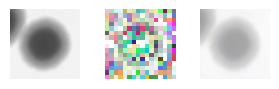

strain --------  ylcG


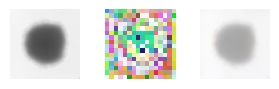

strain --------  yidF


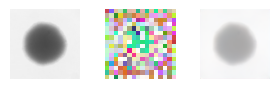

strain --------  ppdB


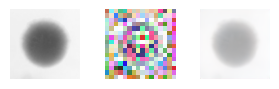

strain --------  yidF


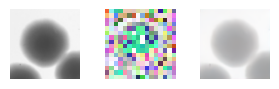

strain --------  yidF


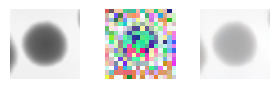

strain --------  proQ


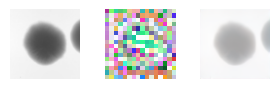

strain --------  yhhI


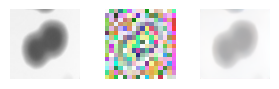

strain --------  yqcR


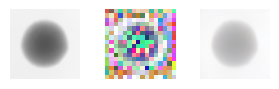

strain --------  clcB


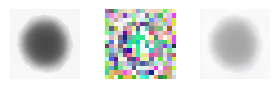

strain --------  yqeN


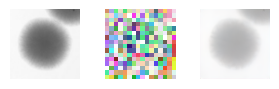

strain --------  ubiH


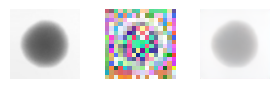

strain --------  eamA


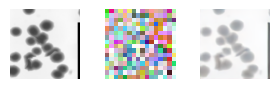

strain --------  yqiG


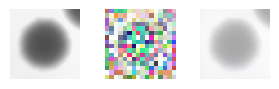

strain --------  ydhV


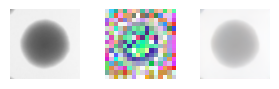

strain --------  proQ


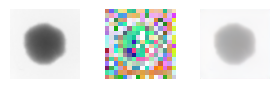

strain --------  yhhI


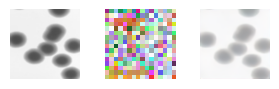

strain --------  ddpA


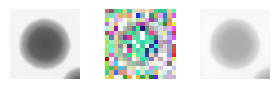

strain --------  sqcX


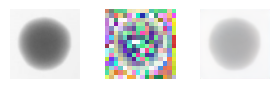

strain --------  yqeN


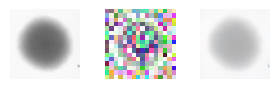

strain --------  yqeN


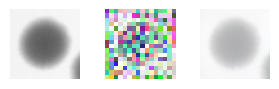

strain --------  yecM


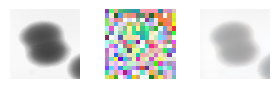

strain --------  yqeH


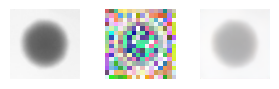

strain --------  ydcC


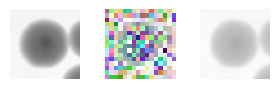

strain --------  proQ


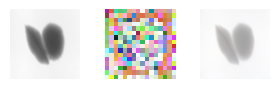

strain --------  yecM


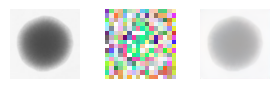

strain --------  recO


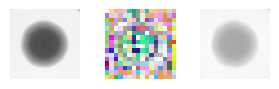

strain --------  yebS


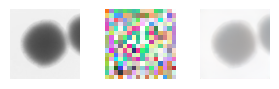

strain --------  eamA


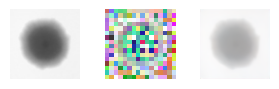

strain --------  yegP


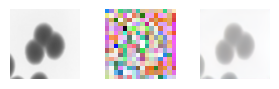

strain --------  ubiH


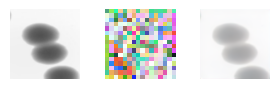

strain --------  yhhI


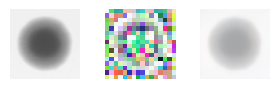

strain --------  yhhI


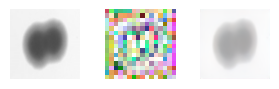

strain --------  yhhI


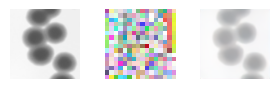

strain --------  yqiG


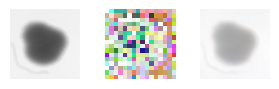

strain --------  fgbF


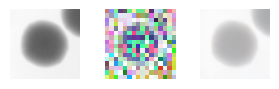

strain --------  ydcC


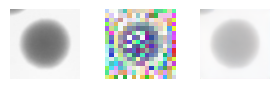

strain --------  sqcX


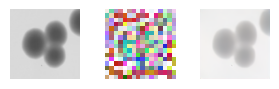

strain --------  ylcG


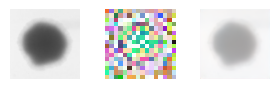

strain --------  yqeH


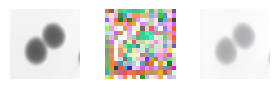

strain --------  dacD


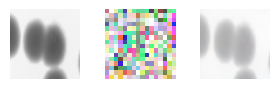

strain --------  ydcC


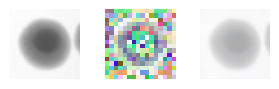

strain --------  envC


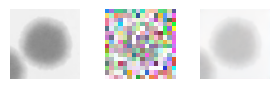

strain --------  envC


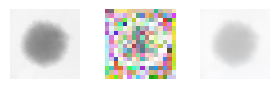

strain --------  proQ


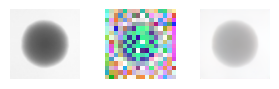

strain --------  recO


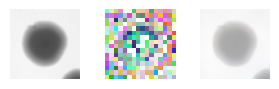

strain --------  ylcG


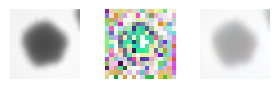

strain --------  qly


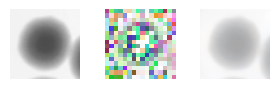

strain --------  yfjD


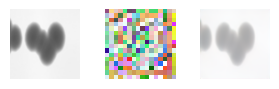

strain --------  proQ


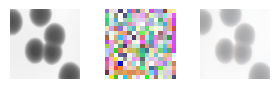

strain --------  qly


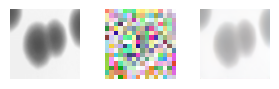

strain --------  yqeN


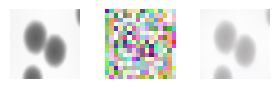

strain --------  yqiG


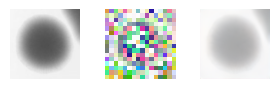

strain --------  sqcX


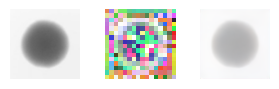

strain --------  yebS


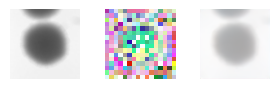

strain --------  yqiG


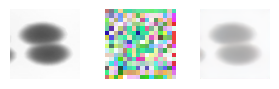

strain --------  ubiH


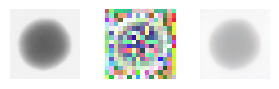

strain --------  phnE


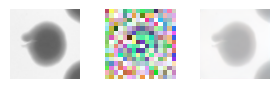

strain --------  yebS


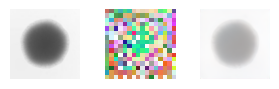

strain --------  yqeH


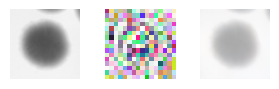

strain --------  sqcX


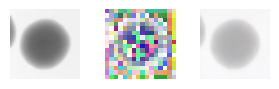

strain --------  yfjD


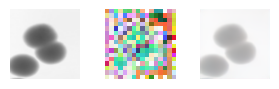

strain --------  yidF


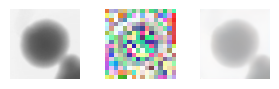

strain --------  ydhV


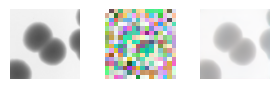

strain --------  tag


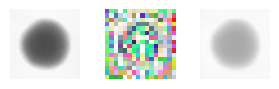

strain --------  yqiG


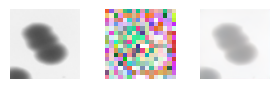

strain --------  eamA


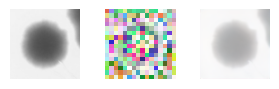

strain --------  ylcG


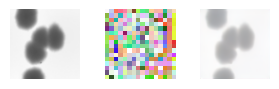

strain --------  dsbB


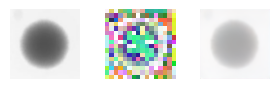

strain --------  yqeN


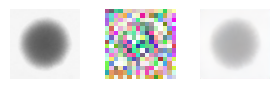

strain --------  yhhI


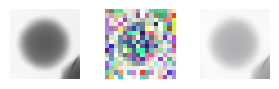

strain --------  sqcX


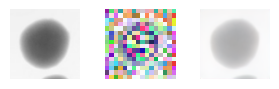

strain --------  ubiH


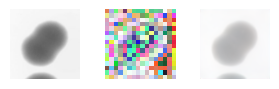

strain --------  deaD


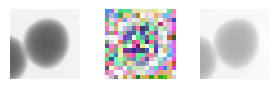

strain --------  sqcX


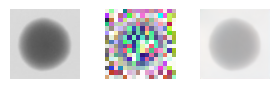

strain --------  ydhV


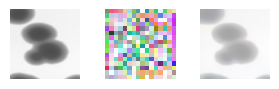

strain --------  phnE


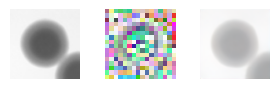

strain --------  phnE


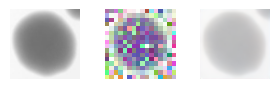

strain --------  yfjD


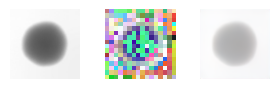

strain --------  yqeH


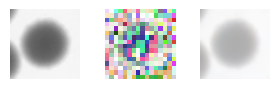

strain --------  yecM


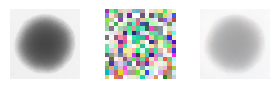

strain --------  yfjD


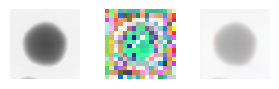

strain --------  sqcX


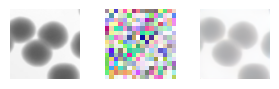

strain --------  yqeT


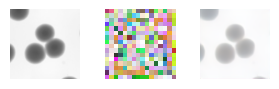

strain --------  yqeH


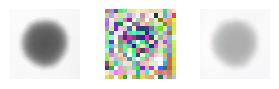

strain --------  ynjE


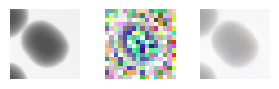

strain --------  deaD


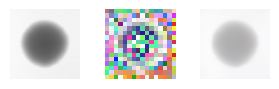

strain --------  fgbF


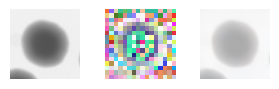

strain --------  sqcX


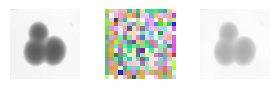

strain --------  ybhR


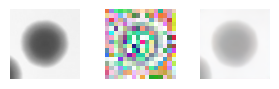

strain --------  tag


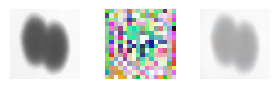

strain --------  yhhI


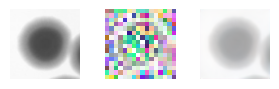

strain --------  yecM


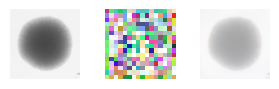

strain --------  fgbF


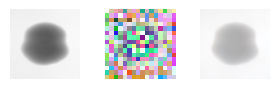

strain --------  qly


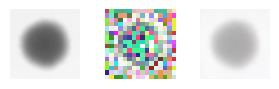

strain --------  ubiH


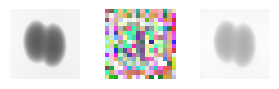

strain --------  yqcR


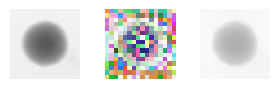

strain --------  glpR


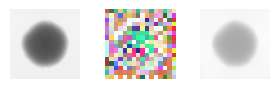

strain --------  ydcC


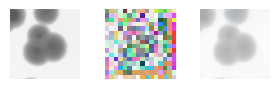

strain --------  yhhI


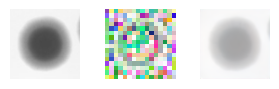

strain --------  yciX


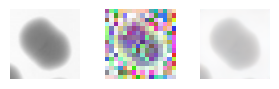

strain --------  yqeT


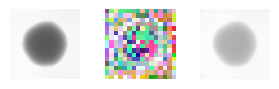

strain --------  ynjE


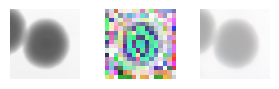

strain --------  recO


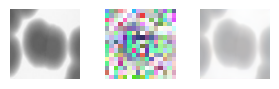

strain --------  yqeH


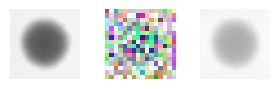

strain --------  fgbF


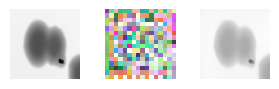

strain --------  yqeT


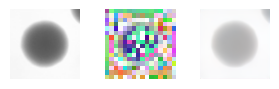

strain --------  sqcX


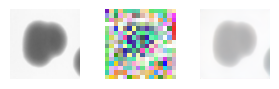

strain --------  fgbF


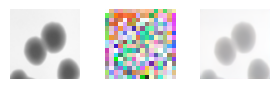

strain --------  dsbB


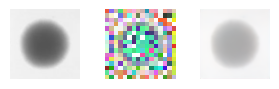

strain --------  fgbF


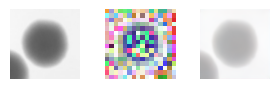

strain --------  fgbF


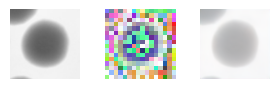

strain --------  yhhI


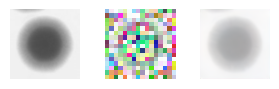

strain --------  yqiG


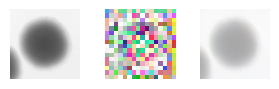

strain --------  yqeH


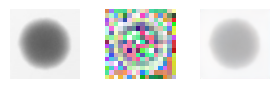

strain --------  ddpA


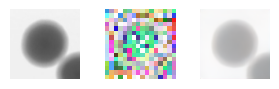

strain --------  fgbF


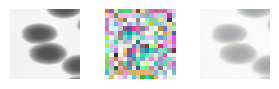

strain --------  ddpA


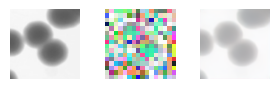

strain --------  fgbF


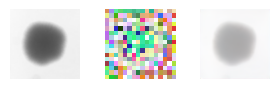

strain --------  yhhI


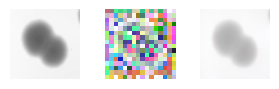

strain --------  yqiG


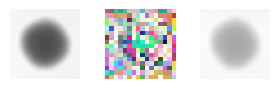

strain --------  ylcG


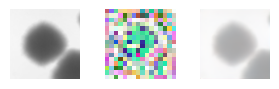

strain --------  ubiH


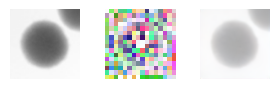

strain --------  proQ


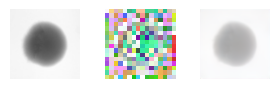

strain --------  yqeN


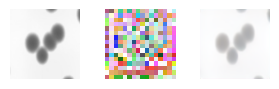

strain --------  dacD


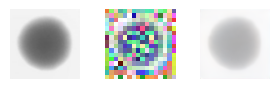

strain --------  yqeH


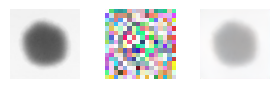

strain --------  qly


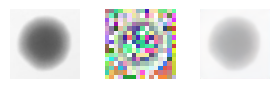

strain --------  ydcC


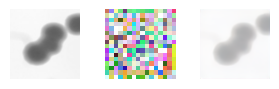

strain --------  yqeT


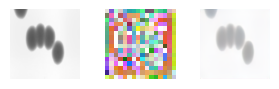

strain --------  yegP


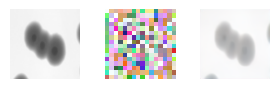

strain --------  yidF


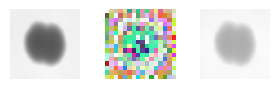

strain --------  ydiQ


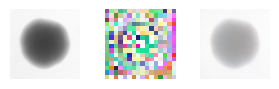

strain --------  yqeT


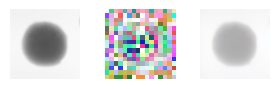

strain --------  ydhV


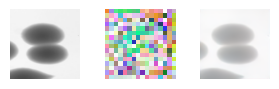

strain --------  qly


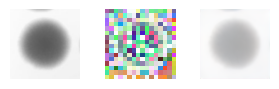

strain --------  ubiH


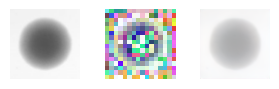

strain --------  yqeT


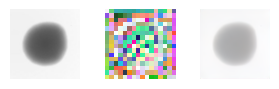

strain --------  yidF


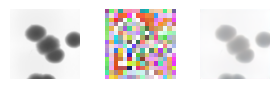

strain --------  yidF


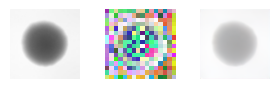

strain --------  yqeT


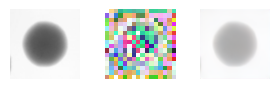

strain --------  yqcR


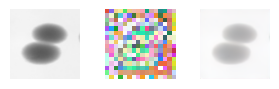

strain --------  dsbB


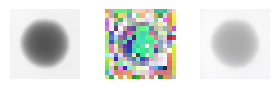

strain --------  proQ


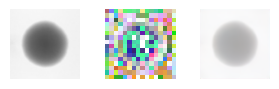

strain --------  qly


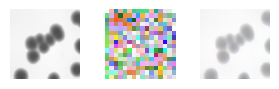

strain --------  ydhV


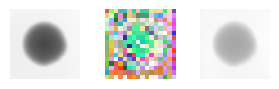

strain --------  yebS


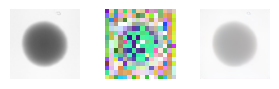

strain --------  eamA


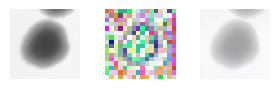

strain --------  sqcX


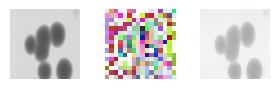

strain --------  sqcX


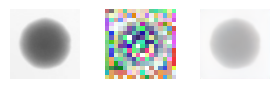

strain --------  ynjE


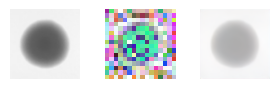

strain --------  recO


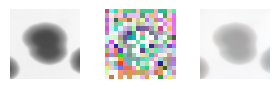

strain --------  ubiH


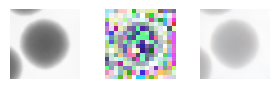

strain --------  yegP


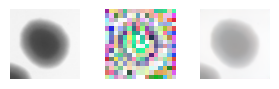

strain --------  ubiH


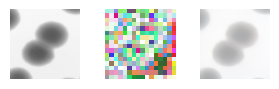

strain --------  yfjD


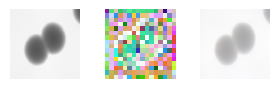

strain --------  proQ


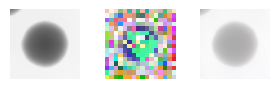

strain --------  yqeN


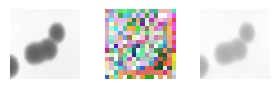

strain --------  yhhI


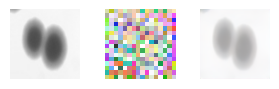

strain --------  sqcX


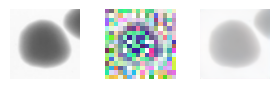

strain --------  yciX


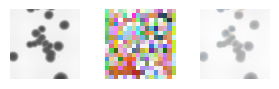

strain --------  yciX


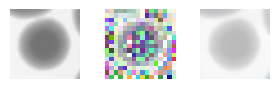

strain --------  phnE


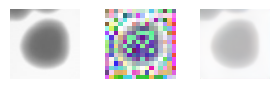

strain --------  sqcX


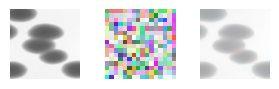

strain --------  recO


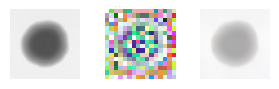

strain --------  tag


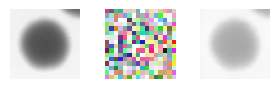

strain --------  yqeH


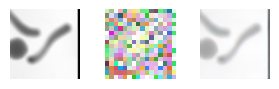

strain --------  ppdB


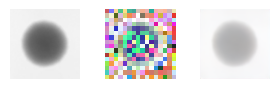

strain --------  proQ


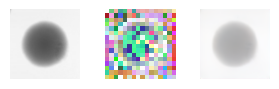

strain --------  ubiH


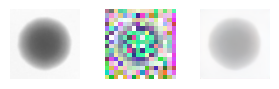

strain --------  yqiG


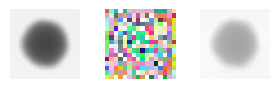

strain --------  ynjE


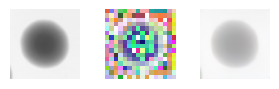

strain --------  eamA


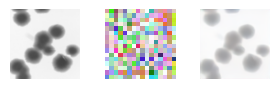

strain --------  fgbF


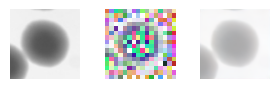

strain --------  ubiH


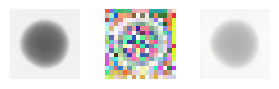

strain --------  yqeT


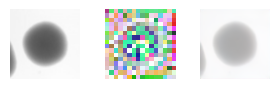

strain --------  yqeN


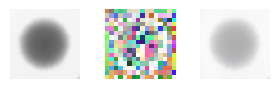

strain --------  yhhI


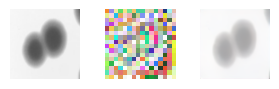

strain --------  yqiG


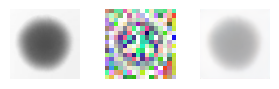

strain --------  fgbF


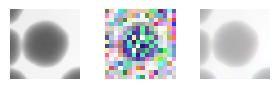

strain --------  yecM


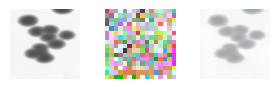

strain --------  recO


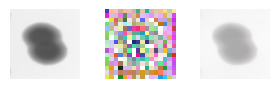

strain --------  qly


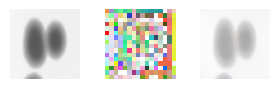

strain --------  ubiH


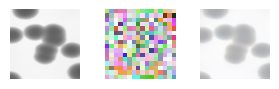

strain --------  clcB


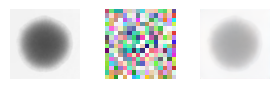

strain --------  deaD


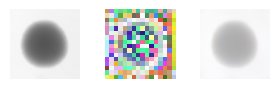

strain --------  yegP


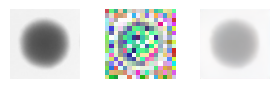

strain --------  yecM


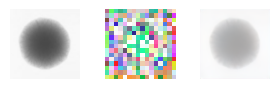

strain --------  deaD


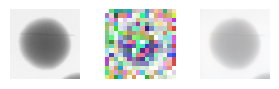

strain --------  ylcG


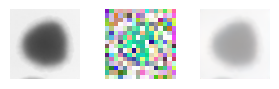

strain --------  yqeN


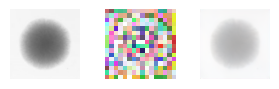

strain --------  yhhI


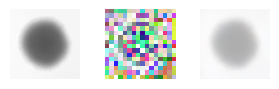

strain --------  ydcC


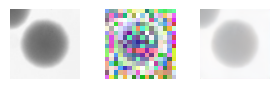

strain --------  yidF


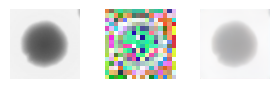

strain --------  ubiH


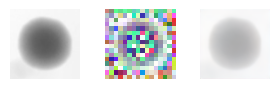

strain --------  eamA


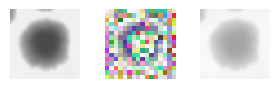

strain --------  yebS


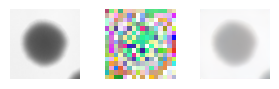

strain --------  sqcX


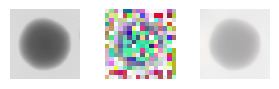

strain --------  sqcX


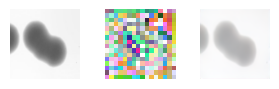

strain --------  yhhI


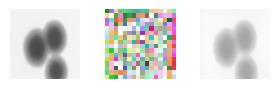

strain --------  ynjE


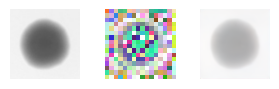

strain --------  ubiH


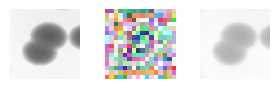

strain --------  yqcR


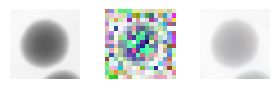

strain --------  ydcC


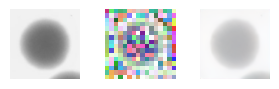

strain --------  ydiQ


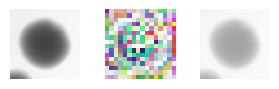

strain --------  ppdB


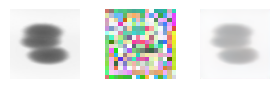

strain --------  yecM


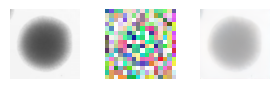

strain --------  yciX


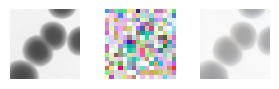

strain --------  ubiH


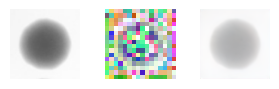

strain --------  yhhI


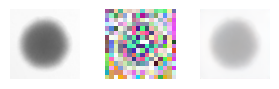

strain --------  ubiH


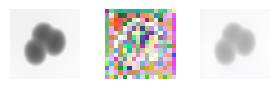

strain --------  ybhR


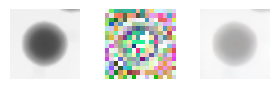

strain --------  ydiQ


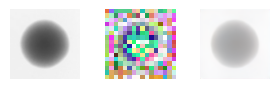

strain --------  ybhR


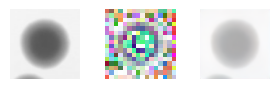

strain --------  yidF


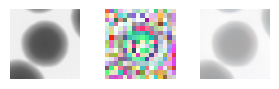

strain --------  recO


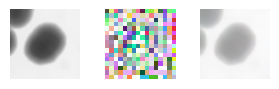

strain --------  xerD


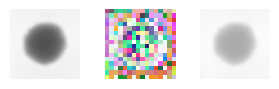

strain --------  yqeN


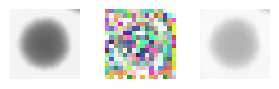

strain --------  ydiQ


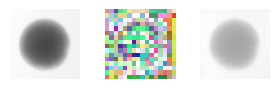

strain --------  ddpA


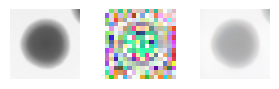

strain --------  yqeT


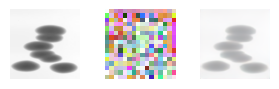

strain --------  envC


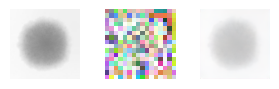

strain --------  sqcX


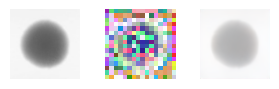

strain --------  ybhR


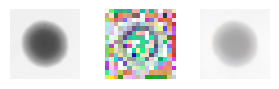

strain --------  glpR


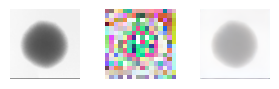

strain --------  yhhI


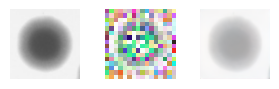

strain --------  phnE


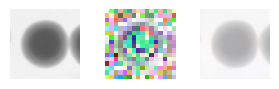

strain --------  ubiH


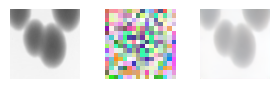

strain --------  yqcR


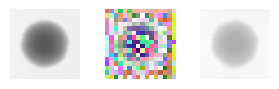

strain --------  ydiQ


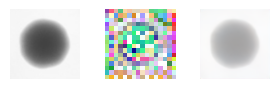

strain --------  ubiH


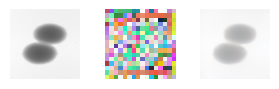

strain --------  phnE


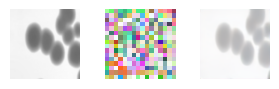

strain --------  ppdB


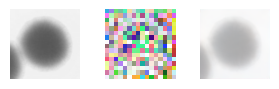

strain --------  ydcC


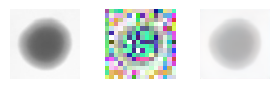

strain --------  yegP


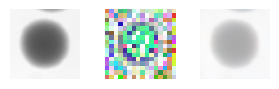

strain --------  bdm


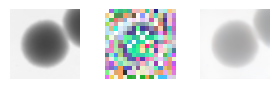

strain --------  yqeH


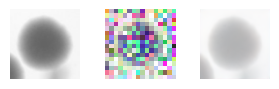

strain --------  fgbF


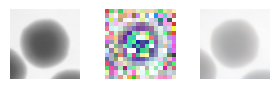

strain --------  sqcX


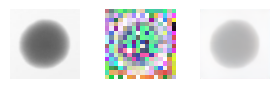

strain --------  yfjD


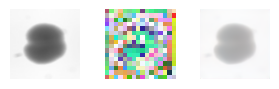

strain --------  yciX


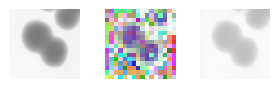

strain --------  ubiH


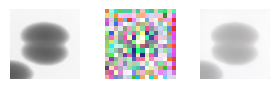

strain --------  glpR


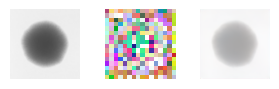

strain --------  yqeT


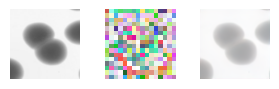

strain --------  deaD


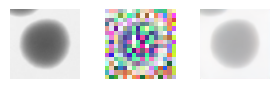

strain --------  yidF


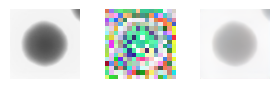

strain --------  sqcX


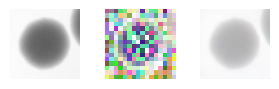

strain --------  recO


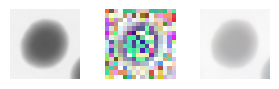

strain --------  qly


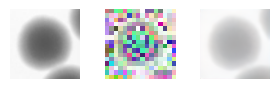

strain --------  ynjE


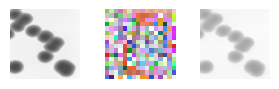

strain --------  ydiQ


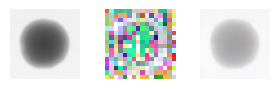

strain --------  qly


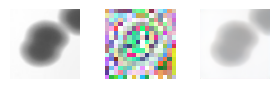

strain --------  clcB


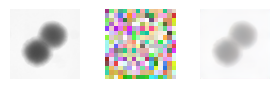

strain --------  yfjD


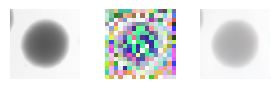

strain --------  deaD


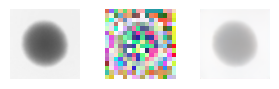

strain --------  yegP


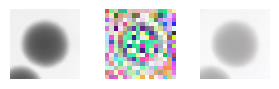

strain --------  yhhI


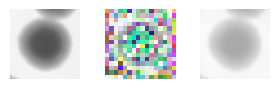

strain --------  fgbF


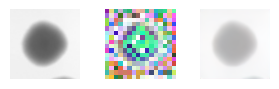

strain --------  qly


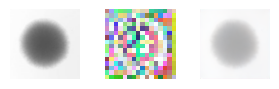

strain --------  yqiG


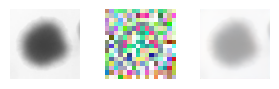

strain --------  clcB


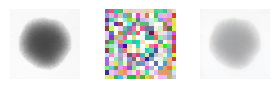

strain --------  fgbF


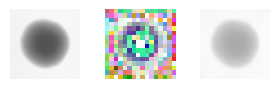

strain --------  ppdB


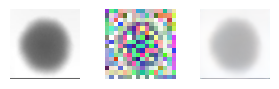

strain --------  ydiQ


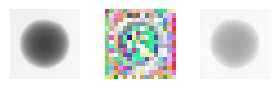

strain --------  ylcG


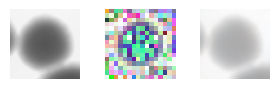

strain --------  phnE


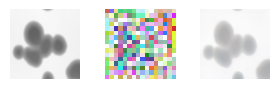

strain --------  yqiG


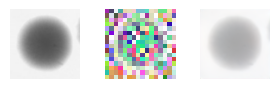

In [142]:
# get latent
vae.eval()
with torch.no_grad():
    for images, targets in test_loader:
        encoded = encode_img(images)
        
        # reconstruct images
        decoded_tensors = decode_img(encoded).cpu() 

print(images[0])

# Display the images
for idx in range(len(test_dataset)):
    fig, axs = plt.subplots(1, 3, figsize=(3 , 1))
    print('strain -------- ', dataset.classes[targets[idx]] )
    # original
    img = tensor_to_pil(images[idx])
    axs[0].imshow(img)
    axs[0].axis('off')
    
    # latent
    latent_img = tensor_to_pil(encoded[idx].cpu())
    axs[1].imshow(latent_img)
    axs[1].axis('off')
    # recon
    recon_img = tensor_to_pil(decoded_tensors[idx])
    axs[2].imshow(recon_img)
    axs[2].axis('off')
    plt.tight_layout()
    plt.show()





## TSNE on latents

In [143]:
latent_list = []
target_list = []

vae.eval()
with torch.no_grad():
    for images, target in train_loader:
        encoded = encode_img(images)
        
        # reconstruct images
        decoded_tensors = decode_img(encoded).cpu() 
        
        target = target.cpu()
        latent_list.append(encoded)
        target_list.append(target)

latents = torch.cat(latent_list)
targets = torch.cat(target_list)
print(latents.shape)
print(targets.shape)

torch.Size([13054, 4, 16, 16])
torch.Size([13054])


In [145]:
len(unique_labels)

38

TypeError: __init__() got an unexpected keyword argument 'bbox'

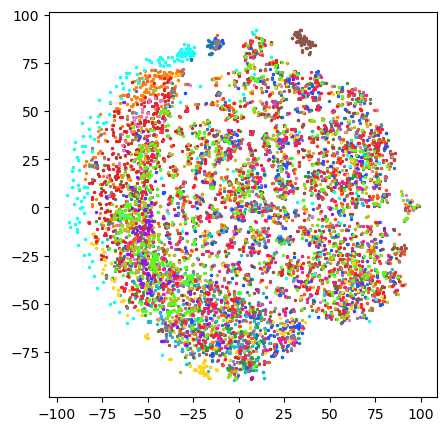

In [180]:
from matplotlib import cm
import matplotlib.colors as mcolors



latents = latents.cpu()
targets = targets.cpu()
latents_2d = latents.reshape(latents.size(0), -1)

# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=10, random_state=0)
tsne_results = tsne.fit_transform(latents_2d.numpy())

# Plot
unique_labels = np.unique(targets.numpy())

# colormap

base_colors = mcolors.TABLEAU_COLORS
tab20c = list(base_colors.values())[0:20]

# Define additional distinct colors
# These are chosen to be distinct but you might want to modify them based on your visualization.
additional_colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#1a55FF", "#FF551a", "#50FF1a", "#FF1a8D", "#7F1aFF",
    "#FFD41a", "#1aFFF5", "#FF1a35"
]

colors_38 = tab20c + additional_colors

plt.figure(figsize=(5, 5))

for label, color in zip(unique_labels, colors_38):
    idx = targets.numpy() == label
    plt.scatter(tsne_results[idx, 0], tsne_results[idx, 1], color=color, label=dataset.classes[label], s=2)

plt.legend(loc='best', bbox = (1.5, 1))
plt.show()

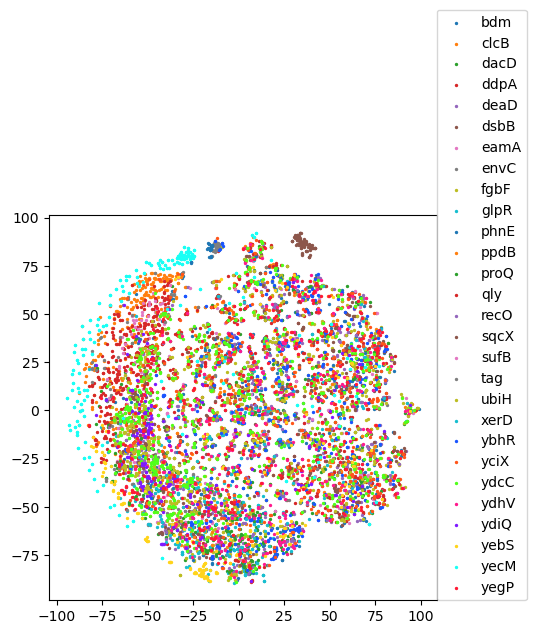

In [181]:
plt.figure(figsize=(5, 5))

for label, color in zip(unique_labels, colors_38):
    idx = targets.numpy() == label
    plt.scatter(tsne_results[idx, 0], tsne_results[idx, 1], color=color, label=dataset.classes[label], s=2)

plt.legend(loc = [1, 0])
plt.show()

In [206]:
from sklearn.metrics import silhouette_score

# Compute the silhouette scores for each target
silhouette_scores = {}

for label in unique_labels:
    idx = (targets == label).numpy()
    if sum(idx) > 1:  # We need at least 2 samples to compute the silhouette score
        
        # Create binary labels: current class vs all other classes
        binary_labels = np.zeros_like(targets.numpy())
        binary_labels[idx] = 1
        
        score = silhouette_score(tsne_results, binary_labels)
        silhouette_scores[dataset.classes[label]] = score

# Rank the targets by their silhouette scores
sorted_targets = sorted(silhouette_scores.items(), key=lambda x: x[1], reverse=True)

# Return the ranked list
sorted_targets[0:5]

ValueError: Found input variables with inconsistent numbers of samples: [10, 13054]

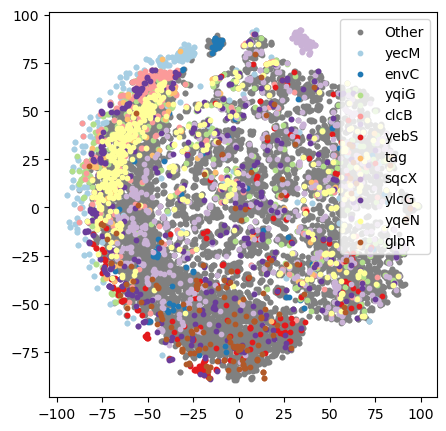

In [183]:
# Get the top 10 classes
n = 10
top_10_classes = [item[0] for item in sorted_targets[:n]]

# Create a colormap for the top 10 classes
colors = plt.cm.Paired(np.linspace(0, 1, 10))
color_map = {cls: colors[i] for i, cls in enumerate(top_10_classes)}

# Plot the t-SNE results
plt.figure(figsize=(5, 5))

# First, plot other samples in grey
other_idx = ~np.isin(targets.numpy(), [dataset.class_to_idx[cls] for cls in top_10_classes])
plt.scatter(tsne_results[other_idx, 0], tsne_results[other_idx, 1], color="grey", label="Other", s=10)

# Then, overlay samples from top 10 classes with unique colors
for i, cls in enumerate(top_10_classes):
    idx = (targets.numpy() == dataset.class_to_idx[cls])
    plt.scatter(tsne_results[idx, 0], tsne_results[idx, 1], color=color_map[cls], label=cls, s = 10)

plt.legend(loc="best")
plt.show()

# Evolution patterns

In [ ]:

#Define preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to a consistent size
    transforms.ToTensor(),
])

# Load dataset
dataset = ImageFolder(root='/hpc/group/youlab/jl841/keio/segmented/', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Split train and test sets
train_indices, test_indices = split_indices(ratio = 0.99)

train_dataset = Subset(dataset, indices=train_indices)
test_dataset = Subset(dataset, indices=test_indices)

# Make dataloaders
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset), shuffle=True)

print(len(train_dataset))
print(len(test_dataset))

In [ ]:
# get latent
vae.eval()
with torch.no_grad():
    for images, targets in test_loader:
        encoded = encode_img(images)
        
        # reconstruct images
        decoded_tensors = decode_img(encoded).cpu() 

print(images[0])

# Display the images
for idx in range(len(test_dataset)):
    fig, axs = plt.subplots(1, 3, figsize=(3 , 1))
    print('strain -------- ', dataset.classes[targets[idx]] )
    # original
    img = tensor_to_pil(images[idx])
    axs[0].imshow(img)
    axs[0].axis('off')
    
    # latent
    latent_img = tensor_to_pil(encoded[idx].cpu())
    axs[1].imshow(latent_img)
    axs[1].axis('off')
    # recon
    recon_img = tensor_to_pil(decoded_tensors[idx])
    axs[2].imshow(recon_img)
    axs[2].axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
latent_list = []
target_list = []

vae.eval()
with torch.no_grad():
    for images, target in train_loader:
        encoded = encode_img(images)
        
        # reconstruct images
        decoded_tensors = decode_img(encoded).cpu() 
        
        target = target.cpu()
        latent_list.append(encoded)
        target_list.append(target)

latents = torch.cat(latent_list)
targets = torch.cat(target_list)
print(latents.shape)
print(targets.shape)

In [ ]:
latents = latents.cpu()
targets = targets.cpu()
latents_2d = latents.reshape(latents.size(0), -1)

# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=10, random_state=0)
tsne_results = tsne.fit_transform(latents_2d.numpy())

# Plot
unique_labels = np.unique(targets.numpy())

# colormap

base_colors = mcolors.TABLEAU_COLORS
colors = list(base_colors.values())[0:20]

plt.figure(figsize=(5, 5))

for label, color in zip(unique_labels, colors):
    idx = targets.numpy() == label
    plt.scatter(tsne_results[idx, 0], tsne_results[idx, 1], color=color, label=dataset.classes[label], s=2)

plt.legend(loc='best', bbox = (1.5, 1))
plt.show()

# Res

In [3]:
import torch.nn as nn
from diffusers import AutoencoderTiny
from PIL import Image
import torch

def conv(n_in, n_out, **kwargs):
    return nn.Conv2d(n_in, n_out, 3, padding=1, **kwargs)

class ResBlock(nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        self.conv = nn.Sequential(
            conv(n_in, n_out), 
            nn.ReLU(), 
            conv(n_in, n_out), 
            nn.ReLU(), 
            conv(n_out, n_out)
            )
        self.skip = nn.Conv2d(n_in, n_out, 1, bias=False) if n_in != n_out else nn.Identity()
        self.fuse = nn.ReLU()
    def forward(self, x):
        return self.fuse(self.conv(x) + self.skip(x))

class AdditionalDecodingLayer(nn.Module):
    def __init__(self, in_channels=3):
        super(AdditionalDecodingLayer, self).__init__()

        self.layers = nn.Sequential(
            conv(in_channels, 32), 
            ResBlock(32, 32), 
            conv (32, in_channels)
            )

    def forward(self, x):
        return torch.sigmoid(self.layers(x))

class CombinedModel(nn.Module):
    def __init__(self, vae, additional_decoder):
        super(CombinedModel, self).__init__()

        self.vae = vae
        self.additional_decoder = additional_decoder

    def forward(self, x):        
        x = x.to(torch.float16)
        latents = self.vae.encode(x).latents
        reconstructed = self.vae.decode(latents).sample.to(torch.float32)
        refined = torch.clamp_max(self.additional_decoder(reconstructed), 1)
        
        return refined

def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.mse_loss = nn.MSELoss()
        self.mae_loss = nn.L1Loss()

    def forward(self, predictions, targets):
        mse = self.mse_loss(predictions, targets)
        mae = self.mae_loss(predictions, targets)
        return  mse + self.alpha * mae

In [4]:
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = AutoencoderTiny.from_pretrained("madebyollin/taesd", torch_dtype=torch.float16)
vae = vae.half()
vae = vae.to(device)
vae.eval()

# Load data
z_values = np.load('julia_set/julia_images.npz')['z']
z_values = torch.from_numpy(z_values).float()
z_values = (z_values - z_values.min()) / (z_values.max() - z_values.min())

# Convert 1-channel to 3-channel images and move to device
z_values = z_values.unsqueeze(1).repeat(1, 3, 1, 1).to(device)

# Train-Test Split
train_data, test_data = train_test_split(z_values, test_size=0.1, random_state=42)

train_dataset = TensorDataset(train_data)
test_dataset = TensorDataset(test_data)

batch_size = 32
lr = 5e-6
gamma = 0.98
weight_decay = 1e-5
min_lr = 5e-9

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for param in vae.parameters():
    param.requires_grad = False
additional_decoder = AdditionalDecodingLayer(in_channels=3)  # Specify the required channels based on VAE output
combined_model = CombinedModel(vae, additional_decoder)
#combined_model.load_state_dict(torch.load('trained/SDTVAE_with_adapter_MAE.0.1.pt'))
for param in combined_model.vae.parameters():
    param.requires_grad = False
combined_model.to(device)
combined_loss = CombinedLoss(alpha = 0.1).to(device)
num_trainable_params = count_trainable_parameters(combined_model)
print(f"Number of trainable parameters: {num_trainable_params}")

optimizer = torch.optim.Adam(additional_decoder.parameters(), lr=lr, weight_decay = weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)  # Adjust step_size and gamma as needed

# Early stopping variables
min_val_loss = float('inf')
patience = 20
no_improve_epochs = 0
warmup_epochs = 10

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    combined_model.train()
    for batch in train_loader:
        imgs, = batch
        imgs = imgs.to(device)
        optimizer.zero_grad()
        refined_imgs = combined_model(imgs)
        loss = combined_loss(refined_imgs, imgs)
        loss.backward()
        optimizer.step()
    
    # Validation loop
    combined_model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            imgs, = batch
            imgs = imgs.to(device)
            refined_imgs = combined_model(imgs)
            val_loss += combined_loss(refined_imgs, imgs).item()

    val_loss /= len(test_loader)

        # Warm-up schedule
    if epoch < warmup_epochs:
        for param_group in optimizer.param_groups:
          param_group['lr'] = lr * (epoch + 1) / warmup_epochs
        # Scheduler step after warmup
        optimizer.step()

    if epoch >= warmup_epochs:
        scheduler.step()
        param_group['lr'] = max(param_group['lr'], min_lr)

    interval = 2 if epoch <40 else 40
    if (epoch + 1) % interval == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}] Train Loss: {loss.item():.7f} | Validation Loss: {val_loss:.7f} | lr: {param_group['lr']:0.9f}")

    # Check early stopping
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        no_improve_epochs = 0
        if (epoch+1) > 60 and (epoch +1) % 2 == 0:
        # Save the model 
            print(f"saving model state at epoch:{epoch + 1} || Val loss: {val_loss:.7f}" )
            torch.save(combined_model.state_dict(), 'trained/SDTVAE_with_Resblock64.pt')

    else:
        no_improve_epochs += 1

    if no_improve_epochs > patience:
        print("Early stopping!")
        break

    scheduler.step()

# Save the model (optional)
#torch.save(combined_model.state_dict(), 'trained/SDTVAE_with_adapter.pt')


FileNotFoundError: [Errno 2] No such file or directory: 'julia_set/julia_images.npz'